In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import torchvision as vision
from torch.utils.data import DataLoader

device = torch.device("cuda")

transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(
            0.5, 0.5
        ),
    ]
)

dataset = vision.datasets.ImageFolder('/home/Student/s4606685/summer_research/oasis-3/png_data', transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [2]:
loader = enumerate(test_loader)
data = next(loader)

In [6]:
data[1][0].shape

torch.Size([16, 1, 128, 128])

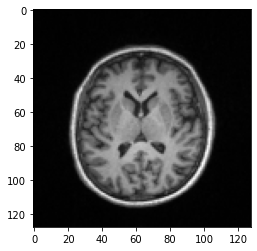

In [11]:
import matplotlib.pyplot as plt
plt.imshow(data[1][0][0][0], cmap='gray')

In [42]:
class q_zx(nn.Module):
    def __init__(self, dim_z, in_channels=1):
        """
        Returns z_samples, z_mean, z_logvar

        Check why in vae_graph.py line 46 is it exp(0.5*) why the 0.5
        Used FC and not convolutional for mean, logvar
        """
        super(q_zx, self).__init__()
        hidden_dims = [32, 64, 128, 256, 512]

        modules = []
        for hdim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=hdim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(hdim),
                    nn.LeakyReLU())
            )
            in_channels = hdim

        self.encoder = nn.Sequential(*modules)

        self.z_mean_layer = nn.Linear(hidden_dims[-1] * 16, dim_z)
        self.z_logvar_layer = nn.Linear(hidden_dims[-1] * 16, dim_z)

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        z_mean = self.z_mean_layer(x)
        z_logvar = self.z_logvar_layer(x)
        return z_mean, z_logvar


# Decoder
class p_xz(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super(p_xz, self).__init__()
        hidden_dims = [512, 256, 128, 64, 32]
        self.decoder_linear = nn.Linear(latent_dims, hidden_dims[0] * 16)
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )
        self.conv_block = nn.Sequential(*modules)
        self.mean_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1,
                      kernel_size=3, padding=1),
            nn.ReLU())
        self.logvar = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=1,
                      kernel_size=3, padding=1),
            nn.ReLU())

    def forward(self, x):
        x = self.decoder_linear(x)
        x = x.view(-1, 512, 4, 4)
        x = self.conv_block(x)
        mu = self.mean_layer(x)
        logvar = self.logvar(x)
        return mu, logvar


class VAE(nn.Module):
    def __init__(self, z_dims):
        super(VAE, self).__init__()
        self.encoder = q_zx(z_dims)
        self.decoder = p_xz(1, z_dims)

    def encode(self, x):
        z_mean, z_logvar = self.encoder(x)
        return z_mean, z_logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        mu, logvar = self.decoder(z)
        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        mu_x, logvar_x = self.decode(z)
        return mu_x, logvar_x, mu, logvar


def loss_function(mu_x, logvar_x, x, mu, logvar):
    # BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    loss_rec = torch.mean(-torch.sum(
        (-0.5 * np.log(2.0 * np.pi))
        + (-0.5 * logvar_x)
        + ((-0.5 / torch.exp(logvar_x)) * (x - mu_x) ** 2.0),
        dim=1,
    ))
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))

    return loss_rec + KLD

model = VAE(20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        mu_x, logvar_x, mu, logvar = model(data)
        loss = loss_function(mu_x, logvar_x, data, mu, logvar)
        loss.backward()
        train_loss += loss.mean().item()
        optimizer.step()
        if batch_idx % 1200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            mu_x, logvar_x, mu, logvar = model(data)
            recon_batch=mu_x
            test_loss += loss_function(mu_x,logvar_x, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch[:n]])
                save_image(comparison.cpu(),
                         'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 4):
    train(epoch)
    test(epoch)

    if epoch%20 == 0:
        filename = 'model-vae-epoch_' + str(epoch) +'.pth.tar'
        checkpoint = {'state_dic':model.state_dict()}
        torch.save(checkpoint, filename)

Train Epoch: 1 [0/106399 (0%)]	Loss: 2.543869
Train Epoch: 1 [19200/106399 (18%)]	Loss: 0.172858
Train Epoch: 1 [38400/106399 (36%)]	Loss: 0.106229
Train Epoch: 1 [57600/106399 (54%)]	Loss: 0.083325
Train Epoch: 1 [76800/106399 (72%)]	Loss: 0.079548
Train Epoch: 1 [96000/106399 (90%)]	Loss: 0.077806
====> Epoch: 1 Average loss: 0.2021
====> Test set loss: 0.0770
Train Epoch: 2 [0/106399 (0%)]	Loss: 0.077551
Train Epoch: 2 [19200/106399 (18%)]	Loss: 0.077160
Train Epoch: 2 [38400/106399 (36%)]	Loss: 0.076537
Train Epoch: 2 [57600/106399 (54%)]	Loss: 0.077969
Train Epoch: 2 [76800/106399 (72%)]	Loss: 0.077278
Train Epoch: 2 [96000/106399 (90%)]	Loss: 0.103523
====> Epoch: 2 Average loss: 0.0888
====> Test set loss: 0.0781
Train Epoch: 3 [0/106399 (0%)]	Loss: 0.077399
Train Epoch: 3 [19200/106399 (18%)]	Loss: 0.077606
Train Epoch: 3 [38400/106399 (36%)]	Loss: 0.076675
Train Epoch: 3 [57600/106399 (54%)]	Loss: 0.077686
Train Epoch: 3 [76800/106399 (72%)]	Loss: 0.076260
Train Epoch: 3 [9600

In [19]:
da

torch.Size([16, 1, 128, 128])

model

In [22]:
data = data[1][0].to(device)

In [43]:
gg = model(data)

In [44]:
gg[0].shape

torch.Size([16, 1, 128, 128])

In [45]:
img = gg[0][0].to('cpu')


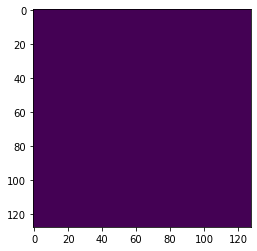

In [46]:
plt.imshow(img[0].detach().numpy())

In [40]:
len(gg)

4